In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.
import branchingdnn as branching

In [2]:
# (train_ds, test_ds, validation_ds) = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

In [3]:
def calcEntropy(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        if isinstance(y_hat, list):
            y_hat = np.array(y_hat)
        sum_entropy = 0
        if y_hat.ndim >1:
            return list(map(calcEntropy,y_hat))
        for i in range(len(y_hat)):
            if y_hat[i] != 0: # log of zero is undefined, see MacKay's book "Information Theory, Inference, and Learning Algorithms"  for more info on this workaround reasoning.
                entropy =y_hat[i] * math.log(y_hat[i],2)
                sum_entropy +=  entropy

        return -sum_entropy
    
def calcEntropy_Tensors(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
#             results = tf.clip_by_value(results, -1e12, 1e12)
#             print("res ", results)
            return tf.reduce_sum(y_hat * results)

        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies
    
def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
#     num = tf.math.log(y_hat)
# #     print("num",num)
#     dem = tf.math.log(tf.constant(2, dtype=y_hat.dtype))
# #     print("dem",dem)
#     E = num / dem
# #     print("E",E)
#     P = y_hat * E
# #     print("p",P)
#     mean = tf.reduce_mean(tf.boolean_mask(P, tf.math.is_finite(P)))
#     print("mean",mean)
#     sumEntropies = mean
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies
    
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)

    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)

    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

In [4]:
class CrossEntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(CrossEntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            softmax = tf.nn.softmax(outputs)
            evidence = self.evidence (outputs)
            alpha = evidence + 1
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
          
            # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            
            self.add_metric(evidence, name=self.name+"_evidence",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs

In [5]:
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay

    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C

    return  cross_entropy_evidence

In [6]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

# outputs =[]
# targets = tf.keras.Input(shape=(10,),name='targets')
# inputs = tf.keras.Input(shape=(227,227,3))
# x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_1 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_1 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)


# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_output"))(branchLayer)
# # branch_output_2 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))
# branch_output_2 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)

# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same")(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)



# branchLayer = tf.keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(x)
# branchLayer = tf.keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# branchLayer = tf.keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# # branchLayer = tf.keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# branch_output_3 = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer)
# # branch_output_3 = (CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("branch_endpoint"))(branchLayer,targets))

# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(4096, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x)
# # output = CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x, targets)

# model = tf.keras.Model(inputs=[inputs,targets], outputs=[output,branch_output_1,branch_output_2,branch_output_3], name="alexnet_branched_entropy")
# loss_fn = loss_function()
# model.compile( loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])



In [7]:
# import time
# root_logdir = os.path.join(os.curdir, "logs\\fit\\")
# checkpoint = tf.keras.callbacks.ModelCheckpoint("alexNetv6_entropy_branched_scratch_40.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto')
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_logdir = get_run_logdir()
# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
# model.fit(train_ds,
#         epochs=40,
#         validation_data=validation_ds,
#         validation_freq=1,
#         # batch_size=1,
#         verbose=1,
#         callbacks=[tensorboard_cb,checkpoint])

In [8]:
dataset = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(224,224), include_targets=True)


augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [9]:
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(224,224,3),
#     alpha=1.0,
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     pooling="avg",
# )


# x = base_model.output
# # x = tf.keras.layers.Dense(1024, activation="relu")(x)
# # x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

# model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


# model.compile(optimizer='SGD', 
#                 loss='categorical_crossentropy',
#                 metrics = ['accuracy'])

In [7]:
train_ds, test_ds, validation_ds = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(224,224), include_targets=False)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [11]:
# EPOCHS = 3
# model.fit(train_ds, epochs=EPOCHS, validation_data = validation_ds, batch_size=32)
# loss, accuracy = model.evaluate(test_ds, batch_size=32)
# # model.save("mobileNetv2_finetuned.hdf5")

In [8]:
model =  tf.keras.models.load_model("mobileNetv2_finetuned.hdf5")
model.evaluate(test_ds)

312/312 [==============================] - 14s 33ms/step - loss: 0.2226 - accuracy: 0.9270


[0.2225652039051056, 0.9269831776618958]

In [12]:
# model.save("models/mobileNetv2_finetuned.hdf5")
# branchPoints = ["block_2_add","block_4_add","block_8_add"]
branchPoints = ["block_2_add"]
loss_fn = loss_function()

In [13]:
# model  = tf.keras.models.load_model('alexNetv6_evidence_branched_contin_30.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})
tf.compat.v1.reset_default_graph() #reset the graph to reset the naming scheme for the new branched model

loss_fn = loss_function()
brevis = (branching.core.branched_model(modelName="models/mobileNetv2_finetuned.hdf5",saveName="mobileNetv2_evidence_conv2d_2",transfer=True,custom_objects="")
            .add_branches(branching.branches.branch.branch_conv2d_mobilenet_evidence,branchPoints, target_input=True)
            .set_dataset(dataset)
            
            )
# brevis.evaluate(test_ds)


targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  block_2_add
TensorShape([None, 56, 56, 24])
inputShape TensorShape([None, 24])


In [14]:
# brevis.save("mobileNetv2_evidence_conv2d_2.hdf5")
brevis.model.summary()

Model: "model_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_____________________________________________________________________________________

In [ ]:
model = brevis.trainTransfer(12, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

In [ ]:
brevis.saveName=("mobileNetv2_entropy_flat_30")
model = brevis.trainTransfer(18, loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

In [18]:
tf.compat.v1.reset_default_graph() #reset the graph to reset the naming scheme for the new branched model
brevis = (branching.core.branched_model(modelName="models/mobileNetv2_finetuned.hdf5",saveName="mobileNetv2_evidence_flat",transfer=True,custom_objects="")
            .add_branches(branching.branches.branch.newBranch_flatten_incept_evid,branchPoints, target_input=True)
            .set_dataset(dataset)
            
            )
# brevis.evaluate(test_ds)

targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  block_2_add
inputShape TensorShape([None, 64])
add Branch to branch point  block_4_add
inputShape TensorShape([None, 64])
add Branch to branch point  block_8_add
inputShape TensorShape([None, 64])


In [19]:
model = brevis.trainTransfer(12, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-407
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/12
1406/1406 [==============================] - ETA: 0s - loss: 8.0359 - classification_loss: 2.2157 - branch_softmax_loss: 2.1841 - branch_softmax_1_loss: 1.9603 - branch_softmax_2_loss: 1.6758 - classification_accuracy: 0.9654 - branch_softmax_accuracy: 0.3132 - branch_softmax_1_accuracy: 0.3544 - branch_softmax_2_accuracy: 0.4570 - branch_softmax_evidence: 0.1327 - branch_softmax_mean_ev_succ: 1.2293 - branch_softmax_mean_ev_fail: 1.3758 - branch_softmax_1_evidence: 0.0788 - branch_softmax_1_mean_ev_succ: 0.7584 - branch_softmax_1_mean_ev_fail: 0.8077 - branch_softmax_2_evidence: 0.0656 - branch_softmax_2_mean_ev_succ: 0.6626 - bra

1406/1406 [==============================] - 433s 295ms/step - loss: 8.0351 - classification_loss: 2.2157 - branch_softmax_loss: 2.1838 - branch_softmax_1_loss: 1.9600 - branch_softmax_2_loss: 1.6756 - classification_accuracy: 0.9654 - branch_softmax_accuracy: 0.3133 - branch_softmax_1_accuracy: 0.3545 - branch_softmax_2_accuracy: 0.4571 - branch_softmax_evidence: 0.1327 - branch_softmax_mean_ev_succ: 1.2293 - branch_softmax_mean_ev_fail: 1.3758 - branch_softmax_1_evidence: 0.0788 - branch_softmax_1_mean_ev_succ: 0.7584 - branch_softmax_1_mean_ev_fail: 0.8077 - branch_softmax_2_evidence: 0.0656 - branch_softmax_2_mean_ev_succ: 0.6626 - branch_softmax_2_mean_ev_fail: 0.6366 - val_loss: 7.8700 - val_classification_loss: 2.2611 - val_branch_softmax_loss: 2.0598 - val_branch_softmax_1_loss: 1.8299 - val_branch_softmax_2_loss: 1.7191 - val_classification_accuracy: 0.9209 - val_branch_softmax_accuracy: 0.2995 - val_branch_softmax_1_accuracy: 0.3744 - val_branch_softmax_2_accuracy: 0.4547 - v

In [20]:
brevis.saveName=("mobileNetv2_evidence_flat_30")
model = brevis.trainTransfer(18, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-408
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/18
1406/1406 [==============================] - ETA: 0s - loss: 4.0479 - classification_loss: 2.1721 - branch_softmax_loss: 0.9353 - branch_softmax_1_loss: 0.6901 - branch_softmax_2_loss: 0.2503 - classification_accuracy: 0.9931 - branch_softmax_accuracy: 0.6646 - branch_softmax_1_accuracy: 0.7542 - branch_softmax_2_accuracy: 0.9116 - branch_softmax_evidence: 0.0078 - branch_softmax_mean_ev_succ: 0.0957 - branch_softmax_mean_ev_fail: 0.0440 - branch_softmax_1_evidence: 0.0120 - branch_softmax_1_mean_ev_succ: 0.1475 - branch_softmax_1_mean_ev_fail: 0.0366 - branch_softmax_2_evidence: 0.0522 - branch_softmax_2_mean_ev_succ: 0.5697 - bra

1406/1406 [==============================] - 436s 299ms/step - loss: 4.0479 - classification_loss: 2.1721 - branch_softmax_loss: 0.9353 - branch_softmax_1_loss: 0.6902 - branch_softmax_2_loss: 0.2503 - classification_accuracy: 0.9931 - branch_softmax_accuracy: 0.6646 - branch_softmax_1_accuracy: 0.7541 - branch_softmax_2_accuracy: 0.9116 - branch_softmax_evidence: 0.0078 - branch_softmax_mean_ev_succ: 0.0957 - branch_softmax_mean_ev_fail: 0.0440 - branch_softmax_1_evidence: 0.0120 - branch_softmax_1_mean_ev_succ: 0.1475 - branch_softmax_1_mean_ev_fail: 0.0366 - branch_softmax_2_evidence: 0.0522 - branch_softmax_2_mean_ev_succ: 0.5697 - branch_softmax_2_mean_ev_fail: 0.0424 - val_loss: 4.9971 - val_classification_loss: 2.2329 - val_branch_softmax_loss: 1.3407 - val_branch_softmax_1_loss: 0.9056 - val_branch_softmax_2_loss: 0.5179 - val_classification_accuracy: 0.9389 - val_branch_softmax_accuracy: 0.5371 - val_branch_softmax_1_accuracy: 0.6617 - val_branch_softmax_2_accuracy: 0.8223 - v

In [21]:
tf.compat.v1.reset_default_graph() #reset the graph to reset the naming scheme for the new branched model
brevis = (branching.core.branched_model(modelName="models/mobileNetv2_finetuned.hdf5",saveName="mobileNetv2_entropy_conv2d",transfer=True,custom_objects="")
            .add_branches(branching.branches.branch.branch_conv2d_entropy,branchPoints, target_input=True)
            .set_dataset(dataset)
            
            )
# brevis.evaluate(test_ds)

targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  block_2_add
add Branch to branch point  block_4_add
add Branch to branch point  block_8_add


In [22]:
model = brevis.trainTransfer(12, loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-409
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/12
1406/1406 [==============================] - 428s 291ms/step - loss: 5.0702 - classification_loss: 0.0886 - branch_softmax_loss: 2.2019 - branch_softmax_1_loss: 1.5525 - branch_softmax_2_loss: 1.2272 - classification_accuracy: 0.9690 - branch_softmax_accuracy: 0.2074 - branch_softmax_1_accuracy: 0.5233 - branch_softmax_2_accuracy: 0.5822 - val_loss: 5.6773 - val_classification_loss: 0.3886 - val_branch_softmax_loss: 2.3974 - val_branch_softmax_1_loss: 1.7095 - val_branch_softmax_2_loss: 1.1818 - val_classification_accuracy: 0.8790 - val_branch_softmax_accuracy: 0.2668 - val_branch_softmax_1_accuracy: 0.5292 - val_branch_softmax_2_a

In [23]:
brevis.saveName=("mobileNetv2_entropy_conv2d_30")
model = brevis.trainTransfer(18, loss="categorical_crossentropy", optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-410
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/18
1406/1406 [==============================] - 456s 309ms/step - loss: 0.2773 - classification_loss: 0.0039 - branch_softmax_loss: 0.1914 - branch_softmax_1_loss: 0.0460 - branch_softmax_2_loss: 0.0360 - classification_accuracy: 0.9990 - branch_softmax_accuracy: 0.9261 - branch_softmax_1_accuracy: 0.9859 - branch_softmax_2_accuracy: 0.9920 - val_loss: 3.2821 - val_classification_loss: 0.1798 - val_branch_softmax_loss: 1.3646 - val_branch_softmax_1_loss: 1.1361 - val_branch_softmax_2_loss: 0.6016 - val_classification_accuracy: 0.9587 - val_branch_softmax_accuracy: 0.6967 - val_branch_softmax_1_accuracy: 0.7472 - val_branch_softmax_2_a

In [24]:
loss_fn = loss_function()
tf.compat.v1.reset_default_graph()
brevis = (branching.core.branched_model(modelName="models/mobileNetv2_finetuned.hdf5",saveName="mobileNetv2_evidence_conv2d",transfer=True,custom_objects="")
            .add_branches(branching.branches.branch.branch_conv2d_inception_evidence,branchPoints, target_input=True)
            .set_dataset(dataset)
            
            )
# brevis.evaluate(test_ds)

targets already present?  False
added targets
Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  block_2_add
TensorShape([None, 56, 56, 24])
TensorShape([None, 54, 54, 32])
TensorShape([None, 52, 52, 32])
TensorShape([None, 86528])
inputShape TensorShape([None, 86528])
add Branch to branch point  block_4_add
TensorShape([None, 28, 28, 32])
TensorShape([None, 26, 26, 32])
TensorShape([None, 24, 24, 32])
TensorShape([None, 18432])
inputShape TensorShape([None, 18432])
add Branch to branch point  block_8_add
TensorShape([None, 14, 14, 64])
TensorShape([None, 12, 12, 32])
TensorShape([None, 10, 10, 32])
TensorShape([None, 3200])
inputShape TensorShape([None, 3200])


In [25]:
brevis.model.summary()

Model: "model_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_____________________________________________________________________________________

In [26]:
model = brevis.trainTransfer(12, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-411
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/12
1406/1406 [==============================] - ETA: 0s - loss: 7.9523 - classification_loss: 2.2225 - branch_softmax_loss: 2.7894 - branch_softmax_1_loss: 1.6485 - branch_softmax_2_loss: 1.2919 - classification_accuracy: 0.9588 - branch_softmax_accuracy: 0.4855 - branch_softmax_1_accuracy: 0.5406 - branch_softmax_2_accuracy: 0.5867 - branch_softmax_evidence: 0.0284 - branch_softmax_mean_ev_succ: 0.4075 - branch_softmax_mean_ev_fail: 0.1427 - branch_softmax_1_evidence: 0.0317 - branch_softmax_1_mean_ev_succ: 0.4360 - branch_softmax_1_mean_ev_fail: 0.1362 - branch_softmax_2_evidence: 0.0353 - branch_softmax_2_mean_ev_succ: 0.4337 - bra

1406/1406 [==============================] - 549s 373ms/step - loss: 7.9511 - classification_loss: 2.2224 - branch_softmax_loss: 2.7887 - branch_softmax_1_loss: 1.6483 - branch_softmax_2_loss: 1.2916 - classification_accuracy: 0.9588 - branch_softmax_accuracy: 0.4856 - branch_softmax_1_accuracy: 0.5407 - branch_softmax_2_accuracy: 0.5868 - branch_softmax_evidence: 0.0284 - branch_softmax_mean_ev_succ: 0.4075 - branch_softmax_mean_ev_fail: 0.1427 - branch_softmax_1_evidence: 0.0317 - branch_softmax_1_mean_ev_succ: 0.4360 - branch_softmax_1_mean_ev_fail: 0.1362 - branch_softmax_2_evidence: 0.0353 - branch_softmax_2_mean_ev_succ: 0.4337 - branch_softmax_2_mean_ev_fail: 0.1782 - val_loss: 8.7184 - val_classification_loss: 2.3282 - val_branch_softmax_loss: 2.0600 - val_branch_softmax_1_loss: 2.7810 - val_branch_softmax_2_loss: 1.5493 - val_classification_accuracy: 0.8634 - val_branch_softmax_accuracy: 0.4333 - val_branch_softmax_1_accuracy: 0.4461 - val_branch_softmax_2_accuracy: 0.5501 - v

In [27]:
brevis.saveName=("mobileNetv2_evidence_conv2d_30")
model = brevis.trainTransfer(18, loss=loss_fn, optimizer=tf.optimizers.SGD(), transfer=False, customOptions="")

Setting Main Layers  and branch layers training to true

customOption: Other
https://app.neptune.ai/cailen01/branchingDNN/e/BRAN-412
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/18
1406/1406 [==============================] - ETA: 0s - loss: 2.2155 - classification_loss: 2.1658 - branch_softmax_loss: 0.0019 - branch_softmax_1_loss: 0.0107 - branch_softmax_2_loss: 0.0371 - classification_accuracy: 0.9978 - branch_softmax_accuracy: 1.0000 - branch_softmax_1_accuracy: 0.9998 - branch_softmax_2_accuracy: 0.9910 - branch_softmax_evidence: 0.0505 - branch_softmax_mean_ev_succ: 0.5053 - branch_softmax_mean_ev_fail: 0.0000e+00 - branch_softmax_1_evidence: 0.0698 - branch_softmax_1_mean_ev_succ: 0.6978 - branch_softmax_1_mean_ev_fail: 3.0467e-05 - branch_softmax_2_evidence: 0.1162 - branch_softmax_2_mean_ev_succ: 1.17

1406/1406 [==============================] - 567s 385ms/step - loss: 2.2155 - classification_loss: 2.1658 - branch_softmax_loss: 0.0019 - branch_softmax_1_loss: 0.0107 - branch_softmax_2_loss: 0.0371 - classification_accuracy: 0.9978 - branch_softmax_accuracy: 1.0000 - branch_softmax_1_accuracy: 0.9998 - branch_softmax_2_accuracy: 0.9910 - branch_softmax_evidence: 0.0505 - branch_softmax_mean_ev_succ: 0.5053 - branch_softmax_mean_ev_fail: 0.0000e+00 - branch_softmax_1_evidence: 0.0698 - branch_softmax_1_mean_ev_succ: 0.6978 - branch_softmax_1_mean_ev_fail: 3.0467e-05 - branch_softmax_2_evidence: 0.1162 - branch_softmax_2_mean_ev_succ: 1.1719 - branch_softmax_2_mean_ev_fail: 0.0136 - val_loss: 5.6164 - val_classification_loss: 2.2175 - val_branch_softmax_loss: 1.5477 - val_branch_softmax_1_loss: 1.2428 - val_branch_softmax_2_loss: 0.6084 - val_classification_accuracy: 0.9535 - val_branch_softmax_accuracy: 0.6959 - val_branch_softmax_1_accuracy: 0.7396 - val_branch_softmax_2_accuracy: 0.

In [53]:
model  = tf.keras.models.load_model('models/mobileNetv2_evidence_conv2d.hdf5', custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"cross_entropy_evidence":loss_function()})

In [58]:
model.evaluate(test_ds)

 1202/10000 [==>...........................] - ETA: 6:35 - loss: 0.2180 - accuracy: 0.9259- ETA: 4:40 - loss: 0.0120 - accu - ETA: 5:34 - loss: 0.0320 - accuracy: 1.00 - ETA: 5:49 - loss: 0.0304 - accuracy:  - ETA: 6:13 - loss: 0.0356 - accuracy: 1.00 - ETA: 6:22 - loss: 0.0359 - accuracy: 1. - ETA: 6:41 - loss: 0.0419 - accuracy: 1. - ETA: 6:57 - loss: 0.0390 - accuracy: 1.00 - ETA: 7:07 - loss: 0.0377 - accuracy: 1. - ETA: 7:19 - loss: 0.0 - ETA: 6:52 - loss: 0.1342 - accuracy: 0.95 - ETA: 6:57 - loss: 0.1315 - accuracy:  - ETA: 7:10 - loss: 0.1248 - accuracy:  - ETA: 7:20 - loss: 0.1204 - accuracy - ETA: 7:25 - loss: 0.2196 - accura - ETA: 7:38 - loss: 0.3047 - accuracy: 0.93 - ETA: 7:40 - loss: 0.3003  - ETA: 7:38 - loss: 0.3212 - accuracy: 0.91 - ETA: 7:41 - loss: 0.3172 - accuracy: 0.91 - ETA: 7:41 - loss: 0.3132 - accuracy: 0.91 - ETA: 7:44 - loss: 0.3095 - accuracy - ETA: 7:47 - loss: 0.3095 - accuracy - ETA: 7:45 - loss: 0.2940 - accu - ETA: 7:35 - loss: 0.2757 - accuracy: 0.9

[0.22296015918254852, 0.9269000291824341]

In [46]:
def collectEvidence_branches(model,test_ds, evidence=True):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pOverlap=[]

    Outputs = pd.DataFrame()
    pAcc=[]
    for i in range(num_outputs):
        pClass.append([])
        predictions.append([])
        pEvidence.append([])
        pUncertainty.append([])
        pAcc.append([])
        pOverlap.append([])
        # pOutputs.append([])

    for i, (x,y) in enumerate(test_ds):
        # if i > 10:
            # break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        if evidence: 
            result = model.test_on_batch(x,y)
            if i < 1:
            # break
                print(result)
            for j in range(num_outputs):
#                 print("output",j)
                pClass[j].append(tf.argmax(y[0]).numpy())
#                 print("class",pClass[j][i])
                pAcc[j].append(result[j+(num_outputs+1)])  
#                 print("acc",pAcc[j][i])
                if j ==0:
                    pEvidence[j].append(0)
                else:
#                     print("evid Number",((num_outputs * 2)+1), " ", ((j-1)*3))
                    pEvidence[j].append(result[((num_outputs * 2) + 1)+((j-1)*3)])
#                 print("evid",pEvidence[j][i])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
#                 print("overlap",pOverlap[j][i])
        else:
            result = model.predict(x)[0]
#             print(result)

            for j in range(num_outputs):
                pClass[j].append(tf.argmax(y[0]).numpy())
                # print(pClass[j])
                # print(result)
                prediction = np.argmax(result[j])
                if prediction == pClass[j][i]:
                    pAcc[j].append(1)  
                else:
                    pAcc[j].append(0)  
                # print(branching.utils.calcEntropy_Tensors(result[j]).numpy())
                pEvidence[j].append(branching.utils.calcEntropy_Tensors(result[j]).numpy()[0])

                pOverlap[j].append(pAcc[0][i] - pAcc[j][i])
        '''
        overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
    Outputs=[]
    for j in range(num_outputs):
        Predictions = pd.DataFrame({"label":pClass[j],"evidence":pEvidence[j],"Acc":pAcc[j], "overlap":pOverlap[j]})
        Outputs.append(Predictions)
    return Outputs

def displayEvidence_cascade(branch_predictions, thresholds=None, output_names=["branch_1","branch_2","branch_3","Main_Exit"], Evidence = True):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    series=[]
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout()
    Outputs=pd.DataFrame()
    #lets reorder the predictions so that the final layer is at the end
    # _branch_predictions.copy()
    _branch_predictions = branch_predictions.copy()
    # print(_branch_predictions)
    _branch_predictions.append(_branch_predictions.pop(0))
    # print(_branch_predictions)
    rollOver_indices = pd.Index([])
    for i, Predictions in enumerate(_branch_predictions):
        #check if rollover is active, if so, select only the predictions whose indexes match the rollover list
        # print(rollOver_indices)
        test_acc = Predictions["Acc"].astype('bool').value_counts()
        test_accuracy = (test_acc.loc[True] /  (test_acc.loc[True] + test_acc.loc[False]))
        if len(rollOver_indices)>0:
            print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
            Predictions = Predictions.iloc[rollOver_indices]
        # print(Predictions.shape)
        Predictions["Acc"]=Predictions["Acc"].astype('bool')
        # Predictions["evidence"]=Predictions["evidence"].()[0]
        acc = Predictions["Acc"].value_counts()
        # print(acc)
        # print((acc.loc[True] , acc.loc[False]))
        _Incorrects_missed = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["overlap"] == 1)] #all the predictions that the main exit got true and the branch got wrong
#         print("incorrects",_Incorrects_missed)
        if len(_Incorrects_missed) > 0 :
#             print("incorrects",_Incorrects_missed)
            mean = _Incorrects_missed.groupby("Acc")["evidence"].mean().iloc[0]
            std = _Incorrects_missed.groupby("Acc")["evidence"].std().iloc[0]
        else:
            print("pred",Predictions.loc[(Predictions['Acc'] == False)])
            mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
            std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]

        print("mean",mean , " std",std)
        
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        
        E_threshold = -1 #-1 is null for threshold
        if thresholds is not None:
            try:
                E_threshold = thresholds[i]
            except:
                print("threshold not supplied for branch {}, using test data".format(i))
                
        if Evidence:
            if E_threshold ==-1:
                E_threshold = mean + std
            Accepted = Predictions.loc[(Predictions["evidence"] >= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] < E_threshold)]
        else: 
            if E_threshold ==-1:
                E_threshold = mean - std
            Accepted = Predictions.loc[(Predictions["evidence"] <= E_threshold)]
            Rejected = Predictions.loc[(Predictions["evidence"] > E_threshold)]
        
        rollOver_indices = Rejected.index
        Incorrects_overlap = Accepted.loc[(Accepted['Acc'] == False) & (Accepted["overlap"] == 0)].count().iloc[0]
        print(Accepted.shape[0])
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Predictions": len(Predictions.index),
                "test_accuracy": test_accuracy,
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Accepted.shape[0]/(Predictions.shape[0]),
                "accepted_correct":Accepted.loc[(Predictions['Acc'] == True)].shape[0],
                "accepted_incorrect":Accepted.loc[(Predictions['Acc'] == False)].shape[0],
                "accepted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].shape[0])/ Accepted.shape[0],
                "overlap_adjusted_accuracy":(Accepted.loc[(Accepted['Acc'] == True)].count()[0] + Incorrects_overlap) / Accepted.count()[0],
                "M(T) B(F)":Accepted.loc[(Accepted["overlap"] == 1)].count().iloc[0],
                "M(F) B(T)":Accepted.loc[(Accepted["overlap"] ==-1)].count().iloc[0],
                "M(F) B(F) overlap":Incorrects_overlap,
                },index=[i]))
#         print("TT",Accepted.loc[(Accepted["Acc"] ==True) & (Accepted["overlap"] == 0)])
#         print("TF",Accepted.loc[(Accepted["overlap"] == 1)])
#         print("FT",Accepted.loc[(Accepted["overlap"] == -1)])
#         print("FF",Accepted.loc[(Accepted["Acc"] ==False) & (Accepted["overlap"] == 0)])
        axs[round(int(i/2)), round(i%2)]
    # fig, axs = plt.subplots(1, 2)
        # axs[round(int(i/2)), round(i%2)].suptitle('Horizontally stacked subplots')
        axs[round(int(i/2)), round(i%2)].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
        axs[round(int(i/2)), round(i%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
        axs[round(int(i/2)), round(i%2)].plot(np.repeat(E_threshold,11),'b--')
        axs[round(int(i/2)), round(i%2)].title.set_text(output_names[i])
    
    for ax in fig.axes:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axLine, axLabel = ax.get_legend_handles_labels()
            lines=(axLine)
            labels=(axLabel)
    fig.text(0.5, 0.01, 'Items Exit at Branch', ha='center', va='center')
    fig.text(0.01, 0.5, 'Accuracy %', ha='center', va='center', rotation='vertical')
    # fig.legend(lines, labels,bbox_to_anchor=(1., 1), loc=2,borderaxespad=0.,frameon=True)
    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs

In [59]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
train_labels = tf.keras.utils.to_categorical(train_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
def augment_images(image, label,input_size=(224,224), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

validation_size = 5000
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
shuffle_size = 22500
batch_size=1
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_ds_size = len(list(validation_ds))
validation_ds = (validation_ds.map(augment_images))
v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))
validation_ds = (validation_ds.batch(batch_size=1, drop_remainder=True))

Experiencing connection interruptions. Will try to reestablish communication with Neptune.
Communication with Neptune restored!


In [49]:

# Predictions = collectEvidence_branches(model,test_ds)
validation_Outputs = collectEvidence_branches(model,validation_ds, True)

# print(Outputs)

outputs 4
[3.1898131370544434, 2.161137342453003, 0.1279248297214508, 0.8997544050216675, 0.000996571616269648, 1.0, 1.0, 0.0, 1.0, 0.07632288336753845, 0.7629795670509338, 0.00024929846404120326, 0.028320902958512306, 0.2819879651069641, 0.001221083221025765, 0.19269037246704102, 1.9269037246704102, 0.0]


In [50]:
test_Outputs = collectEvidence_branches(model,test_ds, True)

outputs 4
[2.316770553588867, 2.1611328125, 0.15376195311546326, 0.0002990508219227195, 0.0015768486773595214, 1.0, 1.0, 1.0, 1.0, 2.637917305037263e-06, 2.637917350511998e-05, 0.0, 0.010988399386405945, 0.10988399386405945, 0.0, 0.00037163501838222146, 0.0037163503002375364, 0.0]


In [51]:
# print(test_Outputs)

mean 0.009561432281937439  std 0.0627220393444717
719
rollover enabled, 4281 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 0.0043944476036677045  std 0.02227074220913497
698
rollover enabled, 3583 predictions provided
mean 0.003585334175435121  std 0.01784717069797608
908
rollover enabled, 2675 predictions provided
pred       label  evidence    Acc  overlap
17        3         0  False      0.0
35        0         0  False      0.0
37        7         0  False      0.0
39        3         0  False      0.0
296       4         0  False      0.0
301       1         0  False      0.0
333       3         0  False      0.0
338       7         0  False      0.0
370       3         0  False      0.0
401       0         0  False      0.0
435       4         0  False      0.0
441       8         0  False      0.0
450       5         0  False      0.0
466       1         0  False      0.0
478       7         0  False      0.0
526       4         0  False      0.0
548       3         0  False      0.0
555       0         0  False      0.0
573       5         0  False      0.0
584       8         0  False      0.

<Figure size 432x288 with 0 Axes>

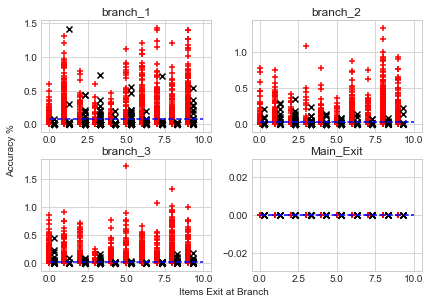

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,5000,0.6942,0.694200,0.072283,0.143800,676,43,0.940195,0.942976,41,2,2
1,branch_2,4281,0.7414,0.706611,0.026665,0.163046,651,47,0.932665,0.938395,43,4,4
2,branch_3,3583,0.8480,0.805470,0.021433,0.253419,881,27,0.970264,0.977974,20,2,7
3,Main_Exit,2675,0.9530,0.920000,0.000000,1.000000,2461,214,0.920000,1.000000,0,0,214


In [55]:
#### version 2
display(displayEvidence_cascade(validation_Outputs, Evidence = True))
# display(displayEvidence_cascade(test_Outputs, Evidence = False))

mean 0.00724401125968572  std 0.044100429902564985
1478
rollover enabled, 8522 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 0.004285258216642008  std 0.025484250740356294
1343
rollover enabled, 7179 predictions provided
mean 0.005170650642565793  std 0.029986948274836285
1768
rollover enabled, 5411 predictions provided
pred       label  evidence    Acc  overlap
25        2         0  False      0.0
37        1         0  False      0.0
47        9         0  False      0.0
59        6         0  False      0.0
61        3         0  False      0.0
68        3         0  False      0.0
110       4         0  False      0.0
125       0         0  False      0.0
127       3         0  False      0.0
164       8         0  False      0.0
184       3         0  False      0.0
200       5         0  False      0.0
224       3         0  False      0.0
226       6         0  False      0.0
255       0         0  False      0.0
275       5         0  False      0.0
281       0         0  False      0.0
309       6         0  False      0.0
313       0         0  False      0.0
324       4         0  False     

<Figure size 432x288 with 0 Axes>

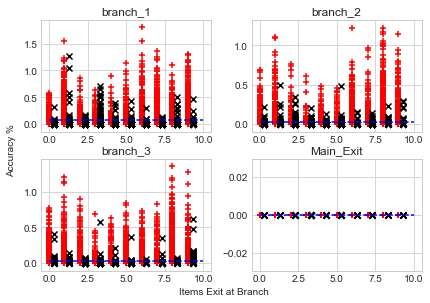

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.6829,0.682900,0.072283,0.147800,1405,73,0.950609,0.957375,63,8,10
1,branch_2,8522,0.7320,0.696433,0.026665,0.157592,1258,85,0.936709,0.945644,73,9,12
2,branch_3,7179,0.8323,0.783396,0.021433,0.246274,1691,77,0.956448,0.967195,58,11,19
3,Main_Exit,5411,0.9471,0.914988,0.000000,1.000000,4951,460,0.914988,1.000000,0,0,460


In [56]:
displayEvidence_cascade(test_Outputs, thresholds=[0.072283,0.026665,0.021433], Evidence = True)

mean 0.004004710083855178  std 0.008881118102279774
1591
rollover enabled, 8409 predictions provided
mean 0.0020127950316792915  std 0.005747526619716405
847
rollover enabled, 7562 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 0.0025505108034397685  std 0.007414918399168136
2572
rollover enabled, 4990 predictions provided
pred       label  evidence    Acc  overlap
37        1         0  False      0.0
47        9         0  False      0.0
57        7         0  False      0.0
125       0         0  False      0.0
164       8         0  False      0.0
218       8         0  False      0.0
226       6         0  False      0.0
228       7         0  False      0.0
255       0         0  False      0.0
264       0         0  False      0.0
273       3         0  False      0.0
309       6         0  False      0.0
313       0         0  False      0.0
352       0         0  False      0.0
355       7         0  False      0.0
356       3         0  False      0.0
394       9         0  False      0.0
428       0         0  False      0.0
456       3         0  False      0.0
464       3         0  False      0.0
518       5         0  False      0.0
531       0         0  False      0.0
537       2        

<Figure size 432x288 with 0 Axes>

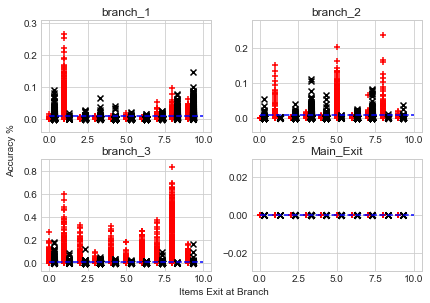

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.4364,0.436400,0.009285,0.159100,971,620,0.610308,0.637335,577,13,43
1,branch_2,8409,0.4857,0.432988,0.008253,0.100725,595,252,0.702479,0.746163,215,20,37
2,branch_3,7562,0.7764,0.750992,0.007197,0.340122,2431,141,0.945179,0.960731,101,24,40
3,Main_Exit,4990,0.9299,0.894990,0.000000,1.000000,4466,524,0.894990,1.000000,0,0,524


In [36]:
displayEvidence_cascade(test_Outputs, thresholds=[0.009285,0.008253,0.007197] ,Evidence = True)

mean 2.3775139060157775  std 0.44754977834901194
rollover enabled, 7356 predictions provided
mean 2.2910808496759185  std 0.4174707782345464
rollover enabled, 5637 predictions provided


c:\users\sanity\appdata\local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mean 1.9400157221468561  std 0.44062205012064976
rollover enabled, 3731 predictions provided
mean 1.0032464265583023  std 0.582510151908757


<Figure size 432x288 with 0 Axes>

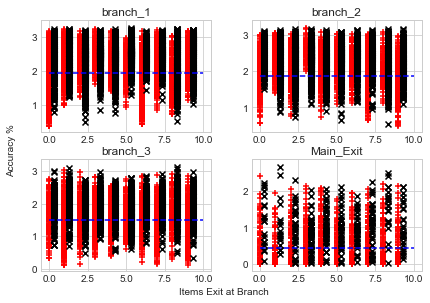

,Branch Name,Predictions,test_accuracy,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,overlap_adjusted_accuracy,M(T) B(F),M(F) B(T),M(F) B(F) overlap
0,branch_1,10000,0.4424,0.442400,1.929964,0.264400,1745,899,0.659985,0.686838,828,32,71
1,branch_2,7356,0.4920,0.423192,1.873610,0.233687,1029,690,0.598604,0.630017,636,27,54
2,branch_3,5637,0.6350,0.558453,1.499394,0.338123,1488,418,0.780693,0.808499,365,26,53
3,Main_Exit,3731,0.9427,0.916912,0.420736,0.776199,2840,56,0.980663,1.000000,0,0,56


Experiencing connection interruptions. Will try to reestablish communication with Neptune.
Experiencing connection interruptions. Will try to reestablish communication with Neptune.
Communication with Neptune restored!
Communication with Neptune restored!


In [42]:
display(displayEvidence_cascade(test_Outputs, Evidence = False))

In [ ]:
'''     overlap
        if zero, both match, if else they don't match
        TT 1-1 =0
        TF 1-0 =1

        FT 0-1 = -1
        FF 0-0 =0
        
        '''
# print(Outputs[1])
displayEvidence(Outputs, Evidence = True)

In [ ]:
### 227,227 sigmoid evidence cifar10 v2
# print(Outputs[0])

displayEvidence(Outputs, Evidence = False)

In [ ]:
### 227,227 sigmoid evidence cifar10
displayEvidence(Predictions)

In [ ]:
### 227,227 sigmoid cifar10
displayEvidence(Predictions)

In [ ]:
### 32,32 crossEvidence cifar10
displayEvidence(Predictions)

In [ ]:

displayEvidence(Predictions)

In [ ]:
displayEvidence(Predictions)


In [ ]:
model_2 = tf.keras.models.load_model('alexNetv6_evidence_test.hdf5',
    custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"crossEntropy_loss":loss_function()})

In [ ]:
Predictions_2 = collectEvidence(model_2,test_ds)

In [ ]:
displayEvidence(Predictions_2)

In [ ]:
def collectEntropy(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    Outputs = pd.DataFrame()
    output_names=["mainExit"]
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        result = model.predict(x)
        pClass.append(tf.argmax(y,1).numpy()[0])
        pred= (tf.nn.softmax(result)[0])

        pEvidence.append(calcEntropy_Tensors(pred).numpy())
        if np.argmax(pred) == np.argmax(y):
            pAcc.append(1)       
        else:
            pAcc.append(0)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"overlap":0})
    return Predictions

def displayEntropy(Predictions):
    output_names=["mainExit"]
    Outputs=pd.DataFrame()
    Predictions["Acc"]=Predictions["Acc"].astype('bool')
    acc = Predictions["Acc"].value_counts()
    print(acc)
    print((acc.loc[True] , acc.loc[False]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = mean - std
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    # Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    print(acc)
    for i,name in enumerate(output_names):
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] < E_threshold)].count()[0],
                # "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                # "Incorrects_overlap":Incorrects_overlap,
                },index=[i]))

    # fig, axs = plt.subplots(1, 2)
    plt.suptitle('Horizontally stacked subplots')
    plt.scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    plt.scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    plt.plot(np.repeat(E_threshold,11),'b--')
    plt.title("evidence")


    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs
    


In [ ]:
# Entropy_predictions = collectEntropy(model_2,test_ds)


In [ ]:
displayEntropy(Entropy_predictions)

In [ ]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
test_images = test_images.reshape(10000, 32,32,3).astype("float32") / 255

# print(y_train)
K= 10 # number of classes
test_labels = tf.keras.utils.to_categorical(test_labels,10)
shuffle_size = 22500
batch_size=1
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def augment_images(image, label,input_size=(227,227), channel_first = False):
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            return image, label
test_ds_size = len(list(test_ds))
# test_ds = (test_ds.map(augment_images))
t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))
test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

In [ ]:
Predictions_mse = collectEvidence(model,test_ds)

In [ ]:
displayEvidence(Predictions_mse)

In [ ]:
#sum entropy 
import pandas as pd
def entropy(x):
    return -(x * math.log(x))
# Data for plotting
t = np.arange(0.00001, 1, 0.01)
print(t.shape)
t_ = np.full((100,), .1)
df = pd.DataFrame([t,t,t_,t,t])
# print(df.transpose())
p = df.apply(calcEntropy,axis=0)
# print(p)
# print(p)
fig, ax = plt.subplots()
ax.plot(t, p)
ax.set(xlabel='Probability of Outcome',ylabel='Entropy of event')

plt.show()


In [ ]:
y_true = [0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0,1,0,0,0,0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.CategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

In [ ]:
y_true = [0]
y_pred = [.0,.01, .9, .0, .0, .0]
ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = ent *1
print("Loss: ",loss)

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
y_pred = [[.9,.0,.0,.0,.0,.0,],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
# y_pred = [.1,.1, .1, .1, .1, .1]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

''' When the answer is correct, CrossE goes down
    When 
    When its wrong, Entropy High
    When its right, Entropy Low
    
    so penalize being right with low entropy and reward being right with high entropy
    
    
    OORRRR train a second model for a branch to determine if you are going to get it right or not?
    Isn't that what ResNet Did? you calculate if the blocks will contribute, was it block drop?
    Binary classification,
    could be done at the branch end as a separate evaulator, using the entropy score and the input to the branch as inputs?
'''


ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = crossE + ent
print("combined Loss: ",loss)

In [ ]:
x = [[.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5]]
x = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

print(list(map(np.argmax,np.array(x))))
def foo(y_pred):
    y_pred = y_pred.numpy()
    pred_label = list(map(np.argmax,np.array(y_pred)))
    return pred_label
%timeit foo(x)

In [ ]:
y_true = tf.constant([[2],[2],[0]])
A = tf.constant([.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5])
B = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

y_pred = tf.constant([[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]])

# new_list = new_list = [list(range(10)) for _ in range(10)]

print(tf.math.argmax(y_pred,1))
pred_labels = tf.math.argmax(y_pred,1)
print(tf.reshape(y_true,pred_labels.shape))
indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
indexes = tf.reshape(indexes,[-1])
# print(tf.gather(B,indexes))
CorrectE = tf.gather(y_pred,indexes)
print(CorrectE)
# print(calcEntropy(CorrectE[0]))


results = tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))
print("results: ",results)



%timeit tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))


crossE = tf.keras.losses.SparseCategoricalCrossentropy()
crossE(y_true,y_pred)
%timeit crossE(y_true,y_pred)
# [
#     [
#         [ 2 20 30  3  6]
#     ]
#     [
#         [ 3 11 16  1  8]
#     ]
# ]

def entropyAddition_noCross(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies
    return loss

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[0,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyAddition(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = scce + (correctEntropies * scce)
    return loss


print("normal CrossE: ",crossE(y_true ,y_pred))

print("normal Entropy",entropyAddition_noCross(y_true2,y_pred2))

print(entropyAddition(y_true2, y_pred2))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([1])
y_pred = tf.constant([0,1, 0, 0, 0, 0])
# print(crossE(y_true,y_pred))

print(tf.cast(1e-8,'float')+1)

In [ ]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyMultiplication(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 1
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies * scce
    return loss


print("normal CrossE: ",crossE(y_true,y_pred))
print(entropyAddition(y_true, y_pred))
# %timeit entropyAddition(y_true, y_pred)

In [ ]:
y_true = tf.constant([[1],[2],[1]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])

def confidenceScore(y_true, y_pred):
        # print(y_pred)
        # print(tf.keras.backend.get_value(y_pred))
        
        # y_true =y_true.numpy()
        # y_pred = y_pred.numpy()
        # AvgConfidence = -1
        pred_labels = tf.math.argmax(y_pred,1)
        # countCorrect=0
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        if tf.equal(tf.size(entropies), 0):
            correctEntropies = 0
        else:
            correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))    
        
        return correctEntropies
    
print(confidenceScore(y_true,y_pred))

In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.9,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]

def foo(x, y):
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    crossE = scce(x, y).numpy()
    return crossE

print(foo(y_true,y_pred))
%timeit foo(y_true,y_pred)

In [ ]:

# Python program explaining 
# where() function 
  
import numpy as np
  
# a is an array of integers.
a = np.array([[1, 2, 3], [4, 5, 6]])
  
print(a)
  
print ('Indices of elements <4')
  
b = np.where(a<5)
print(b)
  
print("Elements which are <4")
print(a[b])

In [ ]:
y_true = [[0],[0],[0]]
y_pred = [[.5,.5, .6, .5, .5, .1],[.5,.5, .6, .5, .5, .2],[.5,.5, .6, .5, .5, .3]]
# y_pred = [[1],[1],[1]]
# print(np.array(y_pred))

####
# Numpy confidence metric version
y_true =np.array(y_true)
y_pred = np.array(y_pred)
def argmax(x):
    return [np.argmax(x)]
pred_labels = list(map(argmax,np.array(y_pred)))
x = np.where(np.equal(y_true,pred_labels) ==True)
y = y_pred[x[0]]
results = calcEntropy(y)
print(results)
if not (results):
    print("A")
print(np.median(results))


In [ ]:
y_true = [[2],[2],[0]]
y_pred = [[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5]]

y_true = [[2]]
y_pred = [[.1,.1, .15, .1, .1, .1]]
def entropyAddition_loss():
    #create a wrapper function that returns a function
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    def entropyAddition(y_true, y_pred):
        #Entropy is added to the CrossE divided by the len of inputs
        pred_labels = tf.math.argmax(y_pred,1)
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))
#         print(pred_label)
        scce = crossE(y_true, y_pred)
        sumEntropy = 0
        loss = correctEntropies + scce
        return loss
    
    return entropyAddition

def custom_loss_multi(y_true, y_pred):
    #CrossE is multiplied by the Entropy
    pred_label = list(map(np.argmax,np.array(y_pred)))
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    sumLoss = 0
    
    for i in range(len(y_pred)):
        loss = crossE(y_true[i], y_pred[i])
#         print('crossE: ',loss)
        if pred_label[i] == y_true[i]:
#             print('calcEntropy ',calcEntropy(y_pred[i]))
            loss = loss * calcEntropy(y_pred[i])
        sumLoss += loss
    sumLoss = sumLoss / len(y_pred)         
    
#     loss = crossE(y_true, y_pred)
#     print("CrossE : ",loss.numpy())
#     print("Loss : ",sumLoss)
    return sumLoss
    ### I want to reduce the entropy of correct answers
    ### if label - pred = 0 (aka correct) then add entropy to crossE
    
    
#     squared_difference = tf.square(np.array(y_true) - np.array(y_pred))
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossEntropyLoss: ",crossE)


crossE = custom_loss_addition(y_true, y_pred).numpy()
print("customLoss_addition: ",crossE)


crossE = custom_loss_multi(y_true, y_pred).numpy()
print("customLoss_multi: ",crossE)

  
# model.compile(loss=custom_loss, optimizer='adam')



In [ ]:

def sub(x,y):
    if x - y == 0:
        return 1
%timeit sub(5,5)

In [ ]:

def sub(x,y):
    if x == y:
        return 0
    
%timeit sub(5,5)